# Tutorial 7: Wiener filter, ML vs MAP, Anscombe transform

In the last tutorial we have explained what inverse problems mean and prpoposed one way to solve them - inverse filtering. Today, we will look at the Wiener filter, which is an "improved" inverse filter. We will also introduce the notion of ML and MAP estimators and compare them on the task of non-blind deconvolution. We will then induce some very simple priors to use with our MAP estimator, and understand how it generalizes the Wiener filter. Finally, on a different note, we will look at how to deal with non-Gaussian noise, such as Poisson noise.


Agenda:
 - Problem with inverse filtering
 - Wiener filter
 - ML estimation
 - MAP estimation
 - Bayesian estimation with simple priors
 - Anscombe transform

In [1]:
import numpy as np
from scipy import fftpack
import cv2
from matplotlib import pyplot as plt
import scipy.signal
import warnings
warnings.filterwarnings('ignore')

Let $f$ be a clean image and $y$ be its blurred version that is obtained by the blur PSF $h$:

$$
y=f\ast h+n \Leftrightarrow Y=F \cdot H+N,
$$

where $n\sim\mathcal{N}(0,\sigma_n^2)$.

We would like to estimate $f$ using a filter $g$ such that
$$
\hat{f} = y \ast g \Leftrightarrow \hat{F}=YG.
$$

## The problem with inverse filtering

In the previous tutorial, we performed inverse filtering by choosing
$$
G = \frac{1}{H}.
$$

Hence
$$
\hat{F} = \frac{Y}{H}.
$$

Let's try it and see what happens.

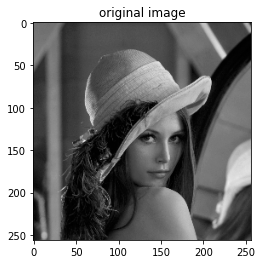

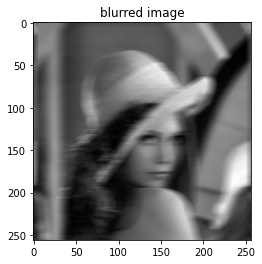

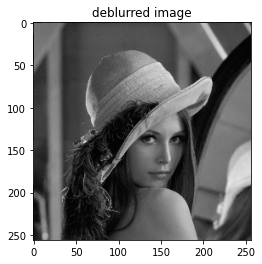

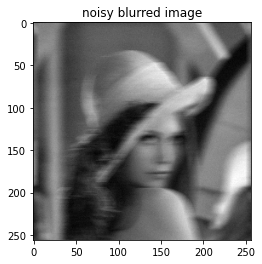

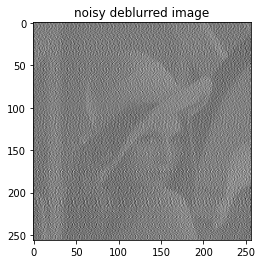

In [7]:
EPSILON = 1e-3
WHITE_LEVEL = 255
SIZE = 256
LENGTH = 15
NOISE_STD = 0.01

def horizontal_motion_blur(size, length):
    center = size // 2
    shift = length // 2
    kernel = np.zeros((size, size))
    kernel[center:center + 1, center - shift:center + shift] = 1
    return kernel / kernel.sum()

def inverse_filter(image, psf):
    image_dft = fftpack.fft2(image)
    psf_dft = fftpack.fft2(fftpack.ifftshift(psf))
    recovered_dft = image_dft / (psf_dft + EPSILON)
    return np.real(fftpack.ifft2(recovered_dft))

image = cv2.imread('lena.jpg', cv2.IMREAD_GRAYSCALE) / WHITE_LEVEL
image = cv2.resize(image, (SIZE, SIZE))
plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

psf = horizontal_motion_blur(SIZE, LENGTH)
blurred_image = scipy.signal.convolve2d(image, psf, mode='same', boundary='wrap')
plt.imshow(blurred_image, cmap='gray')
plt.title('blurred image')
plt.show()

deblurred_image = inverse_filter(blurred_image, psf)
plt.imshow(deblurred_image, cmap='gray')
plt.title('deblurred image')
plt.show()

noisy_blurred_image = blurred_image + np.random.normal(scale=NOISE_STD, size=image.shape)
plt.imshow(noisy_blurred_image, cmap='gray')
plt.title('noisy blurred image')
plt.show()

noisy_deblurred_image = inverse_filter(noisy_blurred_image, psf)
plt.imshow(noisy_deblurred_image, cmap='gray')
plt.title('noisy deblurred image')
plt.show()

Even though the noise didn't significantly affect our perception of the blurry image, the noise was somehow amplified when we tried the recover its sharp version. Let's understand why.

Since
$$
Y = F\cdot H + N,
$$

inverse filtering yields
$$
\hat{F} = \frac{Y}{H} = F + \frac{N}{H}.
$$

The last expression amplifies the noise.

<img src='noise-amplification.png'>

Wiener filter fixes this.

## Wiener Filter

The Wiener filter is defined as
$$
G=\frac{H^{\ast}}{\left|H\right|^2+K},
$$

where
$$
K\left(\xi\right)=\frac{1}{\textit{SNR}\left(\xi\right)}=\frac{S_N\left(\xi\right)}{S_F\left(\xi\right)},
$$

and
$$
S_F\left(\xi\right) = \left|F\left(\xi\right)\right|^2,
$$
$$
S_N\left(\xi\right) = \mathbb{E}\left[\left|N\left(\xi\right)\right|^2\right] = \sigma_n^2.
$$

Using this filter minimizes the expected MSE.

Important cases:

- If $K = 0$, i.e. the noiseless case, then we get the inverse filter $G=\frac{1}{H}$.

- If $K\left(\xi\right)\gg\left|H\left(\xi\right)\right|^2$, the corresponding frequencies are attenuated. This is usually true for the higher frequencies.

<img src='noise-suppresion-wiener.png'>

In practice $K$ is set to be a constant positive scalar which is a hyper-parameter:
- Lower values of $K$ will deblur the image better, but will also amplify the noise.
- Higher values of $K$ will attenuate the noise, but will not completely deblur the image.


Let's implement this.

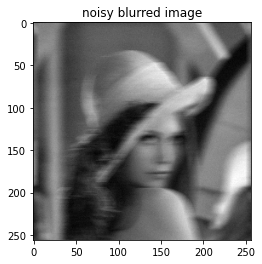

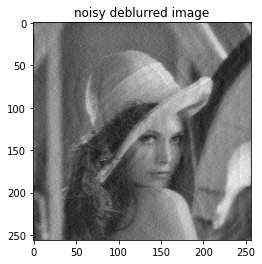

In [11]:
K = 0.01

def wiener_filter(image, psf, k):
    image_dft = fftpack.fft2(image)
    psf_dft = fftpack.fft2(fftpack.ifftshift(psf))
    filter_dft = np.conj(psf_dft) / (np.abs(psf_dft) ** 2 + k)
    recovered_dft = image_dft * filter_dft
    return np.real(fftpack.ifft2(recovered_dft))

plt.imshow(noisy_blurred_image, cmap='gray')
plt.title('noisy blurred image')
plt.show()

noisy_deblurred_image = wiener_filter(noisy_blurred_image, psf, K)
plt.imshow(noisy_deblurred_image, cmap='gray')
plt.title('noisy deblurred image')
plt.show()

Try playing with the values of `K` and see which one works best.

## ML vs MAP estimation

### ML estimator

In ML, we are trying to find the image which maximizes the likelihood, i.e. the one that maximizes the probability of the observed data:
$$
\hat{f}=\arg\max_fP\left(y\mid f\right)
$$

### MAP estimator

In MAP, we are trying to find the image which maximizes the posterior distribution, i.e. the one with the highest probability given the observed data:
$$
\hat{f}=\arg\max_fP\left(f\mid y\right)=\arg\max_f\frac{P\left(y\mid f\right)P\left(f\right)}{P\left(y\right)}=\arg\max_fP\left(y\mid f\right)P\left(f\right).
$$

$P\left(f\right)$ is called the prior distribution, and it is one of the most important aspects in image processing and machine learning in general. Ideally the prior should encapsulate our notion of how an image looks.

### ML deconvolution

From the degradation model, we have $n=y-f\ast h\sim\mathcal{N}(0,\sigma_n^2)$. Hence
$$
P\left(y\mid f\right)=\frac{1}{\left(2\pi\right)^{N/2}\sigma_n^N}\exp\left(-\frac{1}{2\sigma_n^2}\left\Vert y-f\ast h\right\Vert_2^2\right).
$$

We are supposed to maximize the above expression. For simplicity, to avoid the exponents, we can rather maximize the $\log$ of the proposed expression (this won't change anything since $\log$ is monotonically increasing). Thus, if we ignore the constants, and transform the minus sign into minimization, we get
$$
\hat{f}=\arg\min_{f}\frac{1}{2\sigma_n^2}\left\Vert y-f\ast h\right\Vert_2^2.
$$

Using Parseval's identity yields
$$
\hat{F}=\arg\min_{F}\frac{1}{2\sigma_n^2}\left\Vert Y-F \cdot H\right\Vert_2^2.
$$

Hence $\hat{F}=\frac{Y}{H}$. This is nothing but inverse filtering, which we know doesn't work in practice.

### MAP deconvolution

Let's see this with an example of a simple prior.

#### A general simple prior

Let $\mathcal{D}$ be a LSI operator, and let's assume that its transformation on our image, $\mathcal{D}f=f\ast d$, follows an i.i.d. Gaussian distribution with zero mean, i.e. $\mathcal{D}f\sim\mathcal{N}\left(0,\sigma_d^2\right)$. Thus
$$
P\left(f\right)=\frac{1}{\left(2\pi\right)^{N/2}\sigma_d^N}\exp\left(-\frac{1}{2\sigma_d^2}\left\Vert f\ast d\right\Vert_2^2\right).
$$

Inducing this into the MAP estimator and using the same simplifications as before yields
$$
\hat{f}=\arg\max_fP\left(y\mid f\right)P\left(f\right)=\arg\min_{F}\frac{1}{2\sigma_n^2}\left\Vert y-f\ast h\right\Vert_2^2+\frac{1}{2\sigma_d^2}\left\Vert f\ast d\right\Vert_2^2=\arg\min_{F}\left\Vert y-f\ast h\right\Vert_2^2+\frac{\sigma_n^2}{\sigma_d^2}\left\Vert f\ast d\right\Vert_2^2.
$$

Denoting $\lambda=\frac{\sigma_n^2}{\sigma_d^2}$ yields a regularized LS objective funciton:
$$
\hat{f}=\arg\min_{F}\left\Vert y-f\ast h\right\Vert_2^2+\lambda\left\Vert f\ast d\right\Vert_2^2.
$$

It has a closed-form solution in the spatial domain, but computing it requires inverting giant matrices. Instead, we will apply Parseval's identity as before:
$$
\hat{F}=\arg\min_{F}\left\Vert Y-F\cdot H\right\Vert_2^2+\lambda\left\Vert F\cdot D\right\Vert_2^2.
$$

This is a quadratic function in $F$ which has a closed-form solution:
$$
F=\frac{H^{\ast}}{\left|H\right|^2+\lambda\left|D\right|^2}Y.
$$

In practice we estimate $\lambda$ as a constant positive scalar which is a hyper-parameter:
- Lower values of $\lambda$ will put more weight toward deblurring the image.
- Higher values of $\lambda$ will put more weight toward the prior.

Choosing $\mathcal{D}$ to be the identity operator, i.e. $d=\delta$, gives us the Wiener filter, which might explain why using it doesn't work that well in practice.

Let's instead choose $\mathcal{D}$ to be the Laplacian operator. In the second tutorial we introduce its numerical estimation as a convolutional operator which reveals the edges of an image. Using this prior means that our image is smooth, and we can expect it to work better.

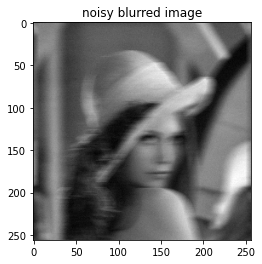

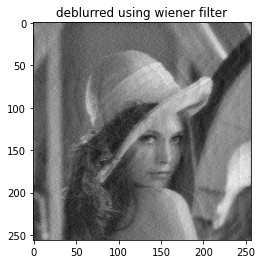

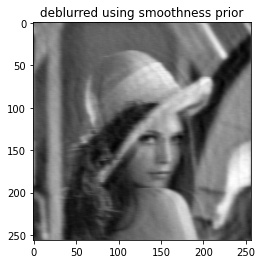

In [15]:
IDENTITY = np.ones((1, 1, ))
LAPLACIAN = np.array(((0, -1, 0, ), (-1, 4, -1, ), (0, -1, 0, ), ))
LAMBDA = 0.01

def map_filter(image, psf, d, lam):
    image_dft = fftpack.fft2(image)
    psf_dft = fftpack.fft2(fftpack.ifftshift(psf))
    d_dft = fftpack.fft2(fftpack.ifftshift(d), shape=image_dft.shape)
    filter_dft = np.conj(psf_dft) / (np.abs(psf_dft) ** 2 + lam * np.abs(d_dft) ** 2)
    recovered_dft = image_dft * filter_dft
    return np.real(fftpack.ifft2(recovered_dft))

plt.imshow(noisy_blurred_image, cmap='gray')
plt.title('noisy blurred image')
plt.show()

wiener_deblurred_image = map_filter(noisy_blurred_image, psf, IDENTITY, LAMBDA)
plt.imshow(wiener_deblurred_image, cmap='gray')
plt.title('deblurred using wiener filter')
plt.show()

smoothness_deblurred_image = map_filter(noisy_blurred_image, psf, LAPLACIAN, LAMBDA)
plt.imshow(smoothness_deblurred_image, cmap='gray')
plt.title('deblurred using smoothness prior')
plt.show()

Try playing with the values of `LAMBDA` and see which one works best.

We can indeed see that using the smoothness prior gives us better results than the naive Wiener filter.

## Anscombe transform

How to deal with Poisson noise? Use a variance-stabilizing transform on the image and treat it as a multivariate isotropic Gaussian, denoise it as you would have denoised standard white noise, and then apply an inverse transform to get the denoised image.

Let's try it using the Anscombe transform.

<img src='anscombe-transform.png'>

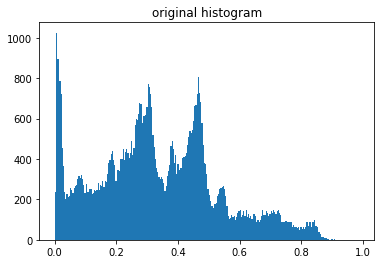

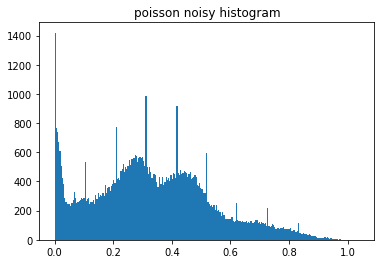

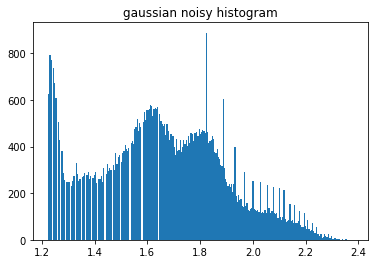

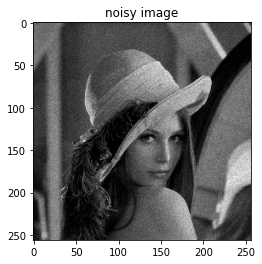

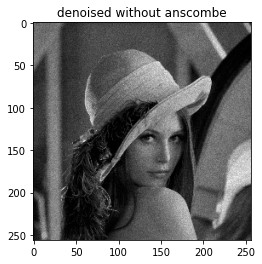

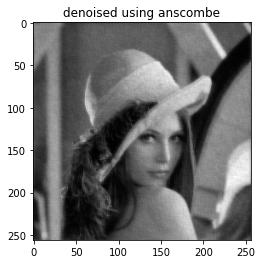

In [5]:
NUM_BINS = 255
LAMBDA = 0.1

def anscombe(image):
    return 2 * np.sqrt(image + 3 / 8)

def inverse_anscombe(image, method='exact'):
    z = (image / 2) ** 2 - 3 / 8
    if method == 'algebraic':
        return z
       
    z += 1 / 4
    if method == 'asymptotic':
        return z
    
    return z + np.sqrt(3 / 2) / (4 * image) - 11 / 8 / (image ** 2) + \
        5 / 8 * np.sqrt(3 / 2) / (image ** 3) 

plt.hist(image.ravel(), bins=NUM_BINS)
plt.title('original histogram')
plt.show()

lam = image * WHITE_LEVEL
poisson_noisy_image = np.random.poisson(lam=lam) / WHITE_LEVEL
plt.hist(poisson_noisy_image.ravel(), bins=NUM_BINS)
plt.title('poisson noisy histogram')
plt.show()

gaussian_noisy_image = anscombe(poisson_noisy_image)
plt.hist(gaussian_noisy_image.ravel(), bins=NUM_BINS)
plt.title('gaussian noisy histogram')
plt.show()

plt.figure()
plt.imshow(poisson_noisy_image, cmap='gray')
plt.title('noisy image')
plt.show()

poisson_denoised_image = map_filter(poisson_noisy_image, IDENTITY, LAPLACIAN, LAMBDA)
plt.figure()
plt.imshow(poisson_noisy_image, cmap='gray')
plt.title('denoised without anscombe')
plt.show()

gaussian_denoised_image = inverse_anscombe(map_filter(gaussian_noisy_image, IDENTITY, LAPLACIAN, LAMBDA))
plt.figure()
plt.imshow(gaussian_denoised_image, cmap='gray')
plt.title('denoised using anscombe')
plt.show()

## Complicated priors

What we saw today was using some preliminary models for priors which have closed-form solutions. The more advanced priors, however, might lead us to more complicated objective functions that we can't solve directly. In these cases we have to resort to iterative solvers which converge to the actual solutions. We willl see more of these in the next tutorials.

## Acknowledgement

- Andrew Zisserman's lectures on Image Analysis.